#### initialization

In [1]:
format short; format compact;
clear all; clc; close all;

%plot inline

## load

#### load data

In [2]:
filename    = 'data/fm_5kbps_d06_batteryfree_wired.lvm';
rx          = lvmread(filename);
rx          = rx(:,2);

#### set 1's and 0's

In [3]:
th = max(rx)/2;
for i = 1:length(rx)
    if rx(i) >= th
        rx(i) = 1;
    else
        rx(i) = 0;
    end
end

#### load message

In [4]:
msg_s = load('data/bf_data.mat');
msg = transpose(msg_s.data);

#### reset

In [ ]:
clearvars -except filename rx th msg_s msg
close all

## preprocessing

#### data cleaning
remove blips of 1's and 0's

In [5]:
clean_count = [];

for i = 2:length(rx)
    % if 0,1,0
    if rx(i-1) == 0 & rx(i) == 1 & rx(i+1) == 0
        rx_c(i) = 0;
        clean_count = [clean_count,0];
    % if 1,0,1
    elseif rx(i-1) == 1 & rx(i) == 0 & rx(i+1) == 1
        rx_c(i) = 1;
        clean_count = [clean_count,1];
    else
        rx_c(i) = rx(i);
    end
end
rx_c(1) = 1;
fprintf('number of bits cleaned: %d\n',length(clean_count))

number of bits cleaned: 8


#### data processing

In [6]:
spb = 384;      % samples per bit
rx_d = [];      % discretized rx
k_check = [];   % bit length matrix, debug
j = 1;          % signal indexer
k=1;            % bit counter
m=0.75245;      % slope of correction
b=95.057;       % y-int of correction

% discretize signal

for i = 2:length(rx_c)
    % if bits are the same
    if rx_c(i) - rx_c(i-1) == 0 
        k=k+1;
    % if 0 -> 1
    elseif rx_c(i) - rx_c(i-1) == 1
        n = round((m*k+b)/spb);         % correction function
         k_check(j:j+n,1) = i;           % debug
         k_check(j:j+n,2) = k;           % debug
         k_check(j:j+n,3) = n;           % debug
        rx_d(j:j+n) = 0;
        j = j + n;
        k = 1;
    % if 1 -> 0
    elseif rx_c(i) - rx_c(i-1) == -1
        n = round((m*k+b)/spb);         % correction function
         k_check(j:j+n,1) = i;           % debug
         k_check(j:j+n,2) = k;           % debug
         k_check(j:j+n,3) = n;           % debug
        rx_d(j:j+n) = 1;
        j = j + n;
        k = 1;
    end
end

rx_n = rx_d;

#### debugging matrices

In [7]:
k_checku = unique(k_check,'rows','stable');
k_tabd = tabulate(k_check(:,2));
k_tab = k_tabd(k_tabd(:,2) > 0,:);
k_tab(:,4) = k_tab(:,1)/384;
k_tab(:,5) = k_tab(:,1)/128;

#### debugging plots

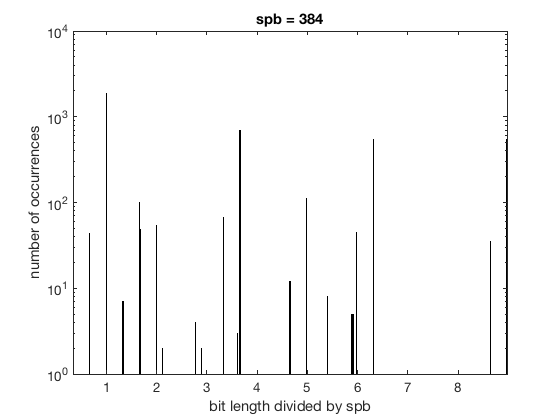

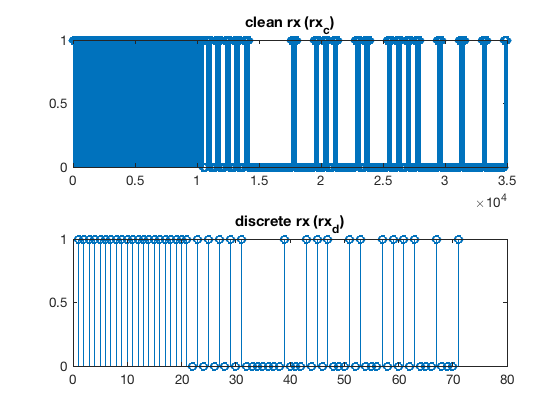

In [8]:
figure
%plt_st = 75;
%plt_end = 110;

subplot(2,1,1)
stem(rx_c(1:round(length(rx_c)/300)))
title('clean rx (rx_c)')
subplot(2,1,2)
stem(rx_d(1:round(length(rx_d)/300)))
title('discrete rx (rx_d)')

figure
kx = k_tab(1:44,4);
ky = k_tab(1:44,2);

bar(kx,ky)
set(gca,'yscale','log');
xlabel('bit length divided by spb');
ylabel('number of occurrences');
title('spb = 384');

## main

#### create header

In [9]:
header = ones(10, 1); header(1:2:10) = 0; header = transpose(header);

#### find data by locating header

In [10]:
h_start = strfind(rx_n, header);

% removing footers and mismatches
check = 1;

while check ~= 0
    check = 0;
    for i=2:length(h_start)        
        if h_start(i) - h_start(i-1) < 200
            h_start(i) = 0;
            check = 1;
        end
    end
    h_start = h_start(h_start ~= 0);
    fprintf('iter\n')
end


iter
iter
iter
iter


#### loading data from header locations

In [11]:
d_start = h_start + length(header);
d_end = d_start + (length(msg)-1);

for i = 1:(length(d_start)-1)
    data_rx(i,:) = rx_n(d_start(i):d_end(i));
end

#### find data by direct match (cheat)

In [12]:
d_loc = strfind(rx_n, msg);
d_loc_diff = (d_loc - [0,d_loc(1:end-1)]);            % debug

for i = 1:length(d_loc)
    data_cheat(i,:) = rx_n(d_loc(i):d_loc(i)+(length(msg)-1));
end

#### ber

In [13]:
ber_count   = 1;
ber         = [];

for i = 1:size(data_rx,1)
   ber(i) = sum(abs(data_rx(i,:)-msg))/length(msg);
end

ber
ber_cum = mean(ber ~= 0)


ber =
  Columns 1 through 13
     0     0     0     0     0     0     0     0     0     0     0     0     0
  Columns 14 through 26
     0     0     0     0     0     0     0     0     0     0     0     0     0
  Columns 27 through 39
     0     0     0     0     0     0     0     0     0     0     0     0     0
  Columns 40 through 45
     0     0     0     0     0     0
ber_cum =
     0


## data plotting

#### find data by direct match (cheat)

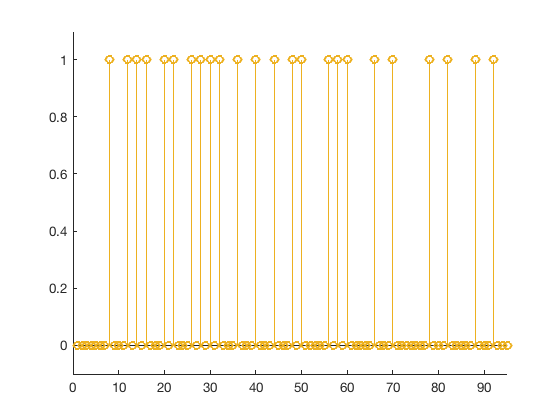

In [14]:
figure
for i = 1:size(data_cheat,1)
    hold on;
    stem(data_cheat(i,:)); 
end
axis([0 length(data_cheat) -0.1 1.1]);

#### find data by locating header

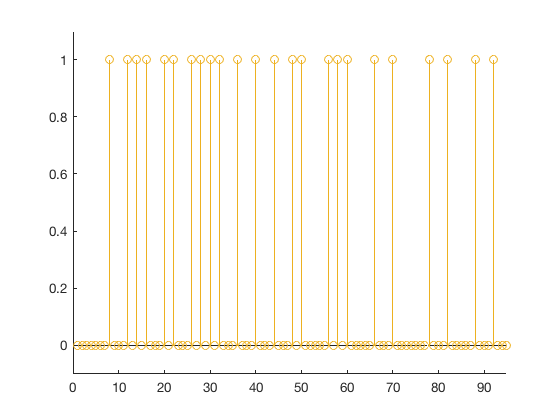

In [42]:
figure
for i = 1:size(data_rx,1)
    hold on;
    stem(data_rx(i,:)); 
end
axis([0 length(data_cheat) -0.1 1.1]);

#### 